In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("/disk/u/gio/rhetoric")
os.getcwd()

'/disk/u/gio/rhetoric'

In [4]:
import torch
from nnsight import LanguageModel
import pandas as pd
from tqdm import tqdm

In [5]:
from src.config import MODEL_NAME

model = LanguageModel(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = model.tokenizer

TRUE_TOK = tokenizer.encode(" True")[-1]
FALSE_TOK = tokenizer.encode(" False")[-1]

In [6]:
from src.prompts import compose_prompt

def get_prefix_mask(enc_clean, enc_rhet, rhet_len):
    """
    Returns a boolean mask (seq_len, ) that is True only for
    the rhetorical prefix in the corrupt prompt.
    - enc_clean: token ids of prompt without rhetoric
    - enc_rhet: token ids of prompt with rhetoric
    - rhet_len: number of prefix tokens added
    """
    mask = torch.zeros_like(enc_rhet, dtype=torch.bool)
    mask[:rhet_len] = True
    return mask

def trace_logits(prompt):
    with model.trace(prompt):
        logits = model.output.logits[0].save()
    return logits[-1] # final-token logits (1, vocab)

In [7]:
from src.utils import load_claims_jsonl
from src.config import CLAIMS_PATH

claims = load_claims_jsonl(CLAIMS_PATH)

In [13]:
from src.config import RHETORIC

claim_text = claims[0].text
rhetoric_class = "authority"
intensity = 2
rhetoric_len = len(
    tokenizer.encode(
        RHETORIC[rhetoric_class][intensity]
    )
)

clean_prompt = compose_prompt(claim_text, rhetoric_class=None)
rhetoric_prompt = compose_prompt(
    claim_text, rhetoric_class=rhetoric_class, intensity=intensity
)

enc_clean = torch.tensor(tokenizer.encode(clean_prompt))
enc_rhet = torch.tensor(tokenizer.encode(rhetoric_prompt))

prefix_mask = get_prefix_mask(enc_clean, enc_rhet, rhetoric_len)

In [33]:
# Baseline Logits
logits_clean = trace_logits(clean_prompt)
logits_rhetoric = trace_logits(rhetoric_prompt)

clean_diff = (logits_clean[TRUE_TOK] - logits_clean[FALSE_TOK]).item()
base_diff = (logits_rhetoric[TRUE_TOK] - logits_rhetoric[FALSE_TOK]).item()

print(f"Clean logit diff: {clean_diff:.3f}")
print(f"Rhetoric logit diff: {base_diff:.3f}")

Clean logit diff: 0.625
Rhetoric logit diff: 1.977


In [16]:
prefix_len = len(enc_rhet) - len(enc_clean)
prefix_len

17

In [18]:
from src.analysis import collect_activations

clean_activations = collect_activations(
    model=model,
    prompt=clean_prompt
)

100%|██████████| 32/32 [00:02<00:00, 14.11it/s]


In [35]:
from tqdm import trange

# Patch and measure loop
patched_activations = []
num_layers = model.config.num_hidden_layers

for l in trange(num_layers):
    
    patch_at_layer = []

    for t in range(len(enc_rhet)):

        if t < prefix_len:
            continue

        with model.trace(enc_rhet):

            # Replace the residual stream output with the clean activations at that token
            model.model.layers[l].output[0][:, t, :] = clean_activations[l][:, t-prefix_len, :]

            # Get the model output logits
            patched_logits = model.output.logits[0].save()

            # Get the logits for the clean target
            patched_target_logits = patched_logits[-1, TRUE_TOK].item().save()

            # Calculate the logit difference
            logit_diff = patched_target_logits - patched_logits[-1, FALSE_TOK].item()

            # Normalize the logit difference
            if base_diff == 0:
                normalized_score = 0.0
            else:
                normalized_score = (logit_diff - base_diff) / (clean_diff - base_diff)

            normalized_score = normalized_score.save()

        # Print the layer, token, and logit difference
        print(f"L{l}, T{t}, LD={normalized_score}")

        # Append the token to our list of logit differences at the current layer
        patch_at_layer.append(normalized_score)
    
    # Append each layer's logit differences list to our overall list of lists
    patched_activations.append(patch_at_layer)

print(f"\\nPatched activations shape: {len(patched_activations)} layers x {len(patched_activations[0])} tokens")


  0%|          | 0/32 [00:00<?, ?it/s]

L0, T17, LD=-0.28901734104046245
L0, T18, LD=-0.04046242774566474
L0, T19, LD=0.023121387283236993
L0, T20, LD=-0.017341040462427744
L0, T21, LD=0.005780346820809248
L0, T22, LD=0.005780346820809248
L0, T23, LD=0.011560693641618497
L0, T24, LD=-0.011560693641618497
L0, T25, LD=-0.0
L0, T26, LD=-0.04046242774566474


  3%|▎         | 1/32 [00:00<00:30,  1.02it/s]

L0, T27, LD=-0.0
L0, T28, LD=-0.24277456647398843
L0, T29, LD=-0.046242774566473986
L0, T30, LD=-0.046242774566473986
L1, T17, LD=-0.2254335260115607
L1, T18, LD=-0.06936416184971098
L1, T19, LD=-0.03468208092485549
L1, T20, LD=0.08670520231213873
L1, T21, LD=-0.011560693641618497
L1, T22, LD=0.1329479768786127
L1, T23, LD=0.10404624277456648
L1, T24, LD=0.028901734104046242
L1, T25, LD=-0.15606936416184972
L1, T26, LD=-0.023121387283236993
L1, T27, LD=-0.07514450867052024
L1, T28, LD=-0.2543352601156069


  6%|▋         | 2/32 [00:01<00:25,  1.16it/s]

L1, T29, LD=-0.017341040462427744
L1, T30, LD=-0.10982658959537572
L2, T17, LD=-0.28901734104046245
L2, T18, LD=-0.08670520231213873
L2, T19, LD=-0.15606936416184972
L2, T20, LD=-0.04046242774566474
L2, T21, LD=0.023121387283236993
L2, T22, LD=0.1676300578034682
L2, T23, LD=0.1907514450867052
L2, T24, LD=0.046242774566473986
L2, T25, LD=-0.27167630057803466
L2, T26, LD=0.057803468208092484


  9%|▉         | 3/32 [00:02<00:23,  1.21it/s]

L2, T27, LD=-0.3352601156069364
L2, T28, LD=-0.4277456647398844
L2, T29, LD=-0.03468208092485549
L2, T30, LD=-0.24855491329479767
L3, T17, LD=-0.4624277456647399
L3, T18, LD=-0.023121387283236993
L3, T19, LD=-0.15606936416184972
L3, T20, LD=-0.07514450867052024
L3, T21, LD=0.057803468208092484
L3, T22, LD=0.1676300578034682
L3, T23, LD=0.2832369942196532
L3, T24, LD=-0.17341040462427745
L3, T25, LD=-0.26011560693641617
L3, T26, LD=0.023121387283236993
L3, T27, LD=-0.5086705202312138
L3, T28, LD=-0.5028901734104047


 12%|█▎        | 4/32 [00:03<00:22,  1.23it/s]

L3, T29, LD=-0.057803468208092484
L3, T30, LD=-0.23699421965317918
L4, T17, LD=-0.06936416184971098
L4, T18, LD=-0.09826589595375723
L4, T19, LD=-0.10982658959537572
L4, T20, LD=-0.057803468208092484
L4, T21, LD=0.017341040462427744
L4, T22, LD=0.1907514450867052
L4, T23, LD=0.32947976878612717
L4, T24, LD=0.27167630057803466
L4, T25, LD=-0.18497109826589594
L4, T26, LD=-0.005780346820809248


 16%|█▌        | 5/32 [00:04<00:21,  1.25it/s]

L4, T27, LD=-0.3930635838150289
L4, T28, LD=-0.5953757225433526
L4, T29, LD=-0.023121387283236993
L4, T30, LD=-0.6069364161849711
L5, T17, LD=-0.12716763005780346
L5, T18, LD=-0.3583815028901734
L5, T19, LD=-0.07514450867052024
L5, T20, LD=-0.023121387283236993
L5, T21, LD=0.03468208092485549
L5, T22, LD=0.15606936416184972
L5, T23, LD=0.36416184971098264
L5, T24, LD=1.2080924855491328
L5, T25, LD=-0.13872832369942195
L5, T26, LD=0.017341040462427744
L5, T27, LD=-0.4046242774566474
L5, T28, LD=-0.6242774566473989


 19%|█▉        | 6/32 [00:04<00:20,  1.26it/s]

L5, T29, LD=-0.028901734104046242
L5, T30, LD=-0.7456647398843931
L6, T17, LD=-0.15028901734104047
L6, T18, LD=-0.27167630057803466
L6, T19, LD=0.011560693641618497
L6, T20, LD=-0.06936416184971098
L6, T21, LD=-0.08670520231213873
L6, T22, LD=0.017341040462427744
L6, T23, LD=0.37572254335260113
L6, T24, LD=1.4739884393063585
L6, T25, LD=-0.15028901734104047
L6, T26, LD=0.011560693641618497


 22%|██▏       | 7/32 [00:05<00:19,  1.27it/s]

L6, T27, LD=-0.2658959537572254
L6, T28, LD=-0.5375722543352601
L6, T29, LD=-0.028901734104046242
L6, T30, LD=-0.815028901734104
L7, T17, LD=0.12716763005780346
L7, T18, LD=-0.1791907514450867
L7, T19, LD=0.1676300578034682
L7, T20, LD=0.10982658959537572
L7, T21, LD=-0.19653179190751446
L7, T22, LD=-0.03468208092485549
L7, T23, LD=0.45664739884393063
L7, T24, LD=1.138728323699422
L7, T25, LD=0.005780346820809248
L7, T26, LD=0.023121387283236993
L7, T27, LD=-0.4277456647398844
L7, T28, LD=-0.16184971098265896


 25%|██▌       | 8/32 [00:06<00:18,  1.27it/s]

L7, T29, LD=-0.05202312138728324
L7, T30, LD=-0.861271676300578
L8, T17, LD=-0.03468208092485549
L8, T18, LD=0.10982658959537572
L8, T19, LD=0.1676300578034682
L8, T20, LD=0.1907514450867052
L8, T21, LD=-0.046242774566473986
L8, T22, LD=0.04046242774566474
L8, T23, LD=0.6878612716763006
L8, T24, LD=1.3583815028901733
L8, T25, LD=0.10982658959537572
L8, T26, LD=0.023121387283236993


 28%|██▊       | 9/32 [00:07<00:18,  1.27it/s]

L8, T27, LD=-0.5260115606936416
L8, T28, LD=-0.5260115606936416
L8, T29, LD=-0.005780346820809248
L8, T30, LD=-0.9190751445086706
L9, T17, LD=-0.08092485549132948
L9, T18, LD=0.3063583815028902
L9, T19, LD=0.2138728323699422
L9, T20, LD=0.2023121387283237
L9, T21, LD=-0.2138728323699422
L9, T22, LD=0.06358381502890173
L9, T23, LD=0.8728323699421965
L9, T24, LD=1.254335260115607
L9, T25, LD=0.2254335260115607
L9, T26, LD=-0.04046242774566474
L9, T27, LD=-0.5549132947976878
L9, T28, LD=-0.6820809248554913


 31%|███▏      | 10/32 [00:08<00:17,  1.27it/s]

L9, T29, LD=-0.10982658959537572
L9, T30, LD=-0.6763005780346821
L10, T17, LD=-0.0
L10, T18, LD=-0.005780346820809248
L10, T19, LD=0.12138728323699421
L10, T20, LD=0.028901734104046242
L10, T21, LD=-0.16184971098265896
L10, T22, LD=-0.1329479768786127
L10, T23, LD=0.9190751445086706
L10, T24, LD=1.300578034682081
L10, T25, LD=0.5722543352601156
L10, T26, LD=0.023121387283236993


 34%|███▍      | 11/32 [00:08<00:16,  1.28it/s]

L10, T27, LD=-0.1907514450867052
L10, T28, LD=-0.3872832369942196
L10, T29, LD=-0.06936416184971098
L10, T30, LD=-0.953757225433526
L11, T17, LD=0.2023121387283237
L11, T18, LD=0.14450867052023122
L11, T19, LD=0.046242774566473986
L11, T20, LD=0.15606936416184972
L11, T21, LD=-0.31213872832369943
L11, T22, LD=-0.23121387283236994
L11, T23, LD=0.9653179190751445
L11, T24, LD=0.9653179190751445
L11, T25, LD=0.5028901734104047
L11, T26, LD=0.05202312138728324
L11, T27, LD=0.09826589595375723
L11, T28, LD=-0.2138728323699422


 38%|███▊      | 12/32 [00:09<00:15,  1.27it/s]

L11, T29, LD=-0.04046242774566474
L11, T30, LD=-1.2947976878612717
L12, T17, LD=-0.1907514450867052
L12, T18, LD=0.04046242774566474
L12, T19, LD=0.03468208092485549
L12, T20, LD=0.028901734104046242
L12, T21, LD=-0.23121387283236994
L12, T22, LD=-0.13872832369942195
L12, T23, LD=0.3988439306358382
L12, T24, LD=0.930635838150289
L12, T25, LD=0.5260115606936416
L12, T26, LD=0.06358381502890173


 41%|████      | 13/32 [00:10<00:14,  1.27it/s]

L12, T27, LD=-0.017341040462427744
L12, T28, LD=-0.44508670520231214
L12, T29, LD=0.08670520231213873
L12, T30, LD=-0.7861271676300579
L13, T17, LD=-0.13872832369942195
L13, T18, LD=-0.005780346820809248
L13, T19, LD=0.011560693641618497
L13, T20, LD=-0.0
L13, T21, LD=-0.028901734104046242
L13, T22, LD=-0.04046242774566474
L13, T23, LD=0.07514450867052024
L13, T24, LD=0.3988439306358382
L13, T25, LD=0.36416184971098264
L13, T26, LD=0.05202312138728324
L13, T27, LD=-0.2832369942196532
L13, T28, LD=-0.37572254335260113


 44%|████▍     | 14/32 [00:11<00:14,  1.27it/s]

L13, T29, LD=0.07514450867052024
L13, T30, LD=-0.017341040462427744
L14, T17, LD=0.04046242774566474
L14, T18, LD=-0.023121387283236993
L14, T19, LD=-0.005780346820809248
L14, T20, LD=-0.005780346820809248
L14, T21, LD=-0.023121387283236993
L14, T22, LD=-0.011560693641618497
L14, T23, LD=0.08092485549132948
L14, T24, LD=0.023121387283236993
L14, T25, LD=0.26011560693641617
L14, T26, LD=0.028901734104046242


 47%|████▋     | 15/32 [00:11<00:13,  1.26it/s]

L14, T27, LD=-0.09248554913294797
L14, T28, LD=-0.3988439306358382
L14, T29, LD=0.07514450867052024
L14, T30, LD=0.9421965317919075
L15, T17, LD=0.07514450867052024
L15, T18, LD=-0.023121387283236993
L15, T19, LD=0.005780346820809248
L15, T20, LD=-0.0
L15, T21, LD=-0.005780346820809248
L15, T22, LD=-0.0
L15, T23, LD=-0.005780346820809248
L15, T24, LD=0.14450867052023122
L15, T25, LD=0.1676300578034682
L15, T26, LD=0.046242774566473986
L15, T27, LD=-0.005780346820809248
L15, T28, LD=-0.2254335260115607


 50%|█████     | 16/32 [00:12<00:12,  1.26it/s]

L15, T29, LD=0.05202312138728324
L15, T30, LD=0.838150289017341
L16, T17, LD=0.2138728323699422
L16, T18, LD=-0.011560693641618497
L16, T19, LD=0.005780346820809248
L16, T20, LD=-0.0
L16, T21, LD=-0.0
L16, T22, LD=0.005780346820809248
L16, T23, LD=-0.005780346820809248
L16, T24, LD=0.10404624277456648
L16, T25, LD=0.1329479768786127
L16, T26, LD=0.03468208092485549


 53%|█████▎    | 17/32 [00:13<00:11,  1.26it/s]

L16, T27, LD=-0.08092485549132948
L16, T28, LD=-0.2023121387283237
L16, T29, LD=0.04046242774566474
L16, T30, LD=1.1618497109826589
L17, T17, LD=0.18497109826589594
L17, T18, LD=-0.017341040462427744
L17, T19, LD=0.005780346820809248
L17, T20, LD=-0.005780346820809248
L17, T21, LD=-0.0
L17, T22, LD=-0.005780346820809248
L17, T23, LD=-0.0
L17, T24, LD=0.011560693641618497
L17, T25, LD=0.12138728323699421
L17, T26, LD=0.017341040462427744
L17, T27, LD=-0.06936416184971098
L17, T28, LD=-0.14450867052023122


 56%|█████▋    | 18/32 [00:14<00:11,  1.26it/s]

L17, T29, LD=-0.017341040462427744
L17, T30, LD=1.2196531791907514
L18, T17, LD=0.11560693641618497
L18, T18, LD=-0.011560693641618497
L18, T19, LD=0.005780346820809248
L18, T20, LD=-0.0
L18, T21, LD=-0.0
L18, T22, LD=-0.005780346820809248
L18, T23, LD=-0.0
L18, T24, LD=0.005780346820809248
L18, T25, LD=0.10982658959537572
L18, T26, LD=-0.0


 59%|█████▉    | 19/32 [00:15<00:10,  1.26it/s]

L18, T27, LD=-0.04046242774566474
L18, T28, LD=-0.1329479768786127
L18, T29, LD=-0.028901734104046242
L18, T30, LD=1.2427745664739884
L19, T17, LD=0.1329479768786127
L19, T18, LD=-0.017341040462427744
L19, T19, LD=-0.005780346820809248
L19, T20, LD=-0.0
L19, T21, LD=-0.0
L19, T22, LD=-0.0
L19, T23, LD=0.005780346820809248
L19, T24, LD=0.005780346820809248
L19, T25, LD=0.12138728323699421
L19, T26, LD=0.011560693641618497
L19, T27, LD=-0.05202312138728324
L19, T28, LD=-0.14450867052023122


 62%|██████▎   | 20/32 [00:15<00:09,  1.26it/s]

L19, T29, LD=-0.04046242774566474
L19, T30, LD=1.1965317919075145
L20, T17, LD=0.08670520231213873
L20, T18, LD=-0.005780346820809248
L20, T19, LD=0.005780346820809248
L20, T20, LD=-0.0
L20, T21, LD=-0.0
L20, T22, LD=0.005780346820809248
L20, T23, LD=-0.0
L20, T24, LD=0.011560693641618497
L20, T25, LD=0.14450867052023122
L20, T26, LD=-0.005780346820809248


 66%|██████▌   | 21/32 [00:16<00:08,  1.26it/s]

L20, T27, LD=-0.10404624277456648
L20, T28, LD=-0.1907514450867052
L20, T29, LD=-0.04046242774566474
L20, T30, LD=1.1965317919075145
L21, T17, LD=0.04046242774566474
L21, T18, LD=-0.005780346820809248
L21, T19, LD=0.005780346820809248
L21, T20, LD=-0.005780346820809248
L21, T21, LD=0.011560693641618497
L21, T22, LD=-0.005780346820809248
L21, T23, LD=0.005780346820809248
L21, T24, LD=-0.0
L21, T25, LD=0.12138728323699421
L21, T26, LD=0.017341040462427744
L21, T27, LD=-0.13872832369942195
L21, T28, LD=-0.12138728323699421


 69%|██████▉   | 22/32 [00:17<00:07,  1.27it/s]

L21, T29, LD=-0.06358381502890173
L21, T30, LD=1.1618497109826589
L22, T17, LD=0.023121387283236993
L22, T18, LD=-0.005780346820809248
L22, T19, LD=-0.0
L22, T20, LD=-0.005780346820809248
L22, T21, LD=0.011560693641618497
L22, T22, LD=0.005780346820809248
L22, T23, LD=-0.0
L22, T24, LD=0.011560693641618497
L22, T25, LD=0.09826589595375723
L22, T26, LD=0.011560693641618497


 72%|███████▏  | 23/32 [00:18<00:07,  1.27it/s]

L22, T27, LD=-0.10982658959537572
L22, T28, LD=-0.10982658959537572
L22, T29, LD=-0.07514450867052024
L22, T30, LD=1.1618497109826589
L23, T17, LD=0.046242774566473986
L23, T18, LD=-0.011560693641618497
L23, T19, LD=-0.0
L23, T20, LD=-0.005780346820809248
L23, T21, LD=0.005780346820809248
L23, T22, LD=-0.005780346820809248
L23, T23, LD=-0.0
L23, T24, LD=0.005780346820809248
L23, T25, LD=0.09826589595375723
L23, T26, LD=0.011560693641618497
L23, T27, LD=-0.12138728323699421
L23, T28, LD=-0.10982658959537572


 75%|███████▌  | 24/32 [00:19<00:06,  1.27it/s]

L23, T29, LD=-0.08670520231213873
L23, T30, LD=1.1734104046242775
L24, T17, LD=0.057803468208092484
L24, T18, LD=-0.005780346820809248
L24, T19, LD=-0.0
L24, T20, LD=-0.005780346820809248
L24, T21, LD=-0.005780346820809248
L24, T22, LD=-0.005780346820809248
L24, T23, LD=-0.0
L24, T24, LD=-0.005780346820809248
L24, T25, LD=0.03468208092485549
L24, T26, LD=0.005780346820809248


 78%|███████▊  | 25/32 [00:19<00:05,  1.28it/s]

L24, T27, LD=-0.12138728323699421
L24, T28, LD=-0.06358381502890173
L24, T29, LD=-0.07514450867052024
L24, T30, LD=1.1849710982658959
L25, T17, LD=0.04046242774566474
L25, T18, LD=-0.005780346820809248
L25, T19, LD=-0.0
L25, T20, LD=0.005780346820809248
L25, T21, LD=0.005780346820809248
L25, T22, LD=-0.005780346820809248
L25, T23, LD=0.005780346820809248
L25, T24, LD=0.011560693641618497
L25, T25, LD=0.023121387283236993
L25, T26, LD=-0.0
L25, T27, LD=-0.10404624277456648
L25, T28, LD=-0.05202312138728324


 81%|████████▏ | 26/32 [00:20<00:04,  1.28it/s]

L25, T29, LD=-0.07514450867052024
L25, T30, LD=1.1502890173410405
L26, T17, LD=0.011560693641618497
L26, T18, LD=-0.005780346820809248
L26, T19, LD=-0.0
L26, T20, LD=-0.0
L26, T21, LD=0.005780346820809248
L26, T22, LD=-0.0
L26, T23, LD=0.005780346820809248
L26, T24, LD=-0.005780346820809248
L26, T25, LD=0.023121387283236993
L26, T26, LD=0.011560693641618497


 84%|████████▍ | 27/32 [00:21<00:03,  1.28it/s]

L26, T27, LD=-0.09248554913294797
L26, T28, LD=-0.07514450867052024
L26, T29, LD=-0.09826589595375723
L26, T30, LD=1.1502890173410405
L27, T17, LD=0.04046242774566474
L27, T18, LD=-0.0
L27, T19, LD=-0.0
L27, T20, LD=-0.005780346820809248
L27, T21, LD=0.005780346820809248
L27, T22, LD=-0.0
L27, T23, LD=0.005780346820809248
L27, T24, LD=-0.005780346820809248
L27, T25, LD=0.023121387283236993
L27, T26, LD=0.005780346820809248
L27, T27, LD=-0.05202312138728324
L27, T28, LD=-0.06358381502890173


 88%|████████▊ | 28/32 [00:22<00:03,  1.28it/s]

L27, T29, LD=-0.04046242774566474
L27, T30, LD=1.0809248554913296
L28, T17, LD=0.023121387283236993
L28, T18, LD=-0.0
L28, T19, LD=-0.0
L28, T20, LD=0.005780346820809248
L28, T21, LD=0.005780346820809248
L28, T22, LD=-0.005780346820809248
L28, T23, LD=-0.0
L28, T24, LD=-0.005780346820809248
L28, T25, LD=-0.023121387283236993
L28, T26, LD=0.005780346820809248


 91%|█████████ | 29/32 [00:22<00:02,  1.28it/s]

L28, T27, LD=-0.03468208092485549
L28, T28, LD=-0.04046242774566474
L28, T29, LD=-0.04046242774566474
L28, T30, LD=1.0578034682080926
L29, T17, LD=0.046242774566473986
L29, T18, LD=-0.0
L29, T19, LD=-0.0
L29, T20, LD=-0.0
L29, T21, LD=-0.005780346820809248
L29, T22, LD=-0.0
L29, T23, LD=-0.005780346820809248
L29, T24, LD=-0.005780346820809248
L29, T25, LD=-0.005780346820809248
L29, T26, LD=-0.0
L29, T27, LD=-0.028901734104046242
L29, T28, LD=-0.028901734104046242


 94%|█████████▍| 30/32 [00:23<00:01,  1.28it/s]

L29, T29, LD=0.017341040462427744
L29, T30, LD=1.046242774566474
L30, T17, LD=0.057803468208092484
L30, T18, LD=-0.0
L30, T19, LD=-0.0
L30, T20, LD=-0.0
L30, T21, LD=-0.0
L30, T22, LD=-0.0
L30, T23, LD=-0.005780346820809248
L30, T24, LD=0.005780346820809248
L30, T25, LD=-0.0
L30, T26, LD=0.005780346820809248


 97%|█████████▋| 31/32 [00:24<00:00,  1.27it/s]

L30, T27, LD=0.005780346820809248
L30, T28, LD=-0.011560693641618497
L30, T29, LD=0.011560693641618497
L30, T30, LD=0.9884393063583815
L31, T17, LD=-0.0
L31, T18, LD=-0.0
L31, T19, LD=-0.0
L31, T20, LD=-0.0
L31, T21, LD=-0.0
L31, T22, LD=-0.0
L31, T23, LD=-0.0
L31, T24, LD=-0.0
L31, T25, LD=-0.0
L31, T26, LD=-0.0
L31, T27, LD=-0.0
L31, T28, LD=-0.0


100%|██████████| 32/32 [00:25<00:00,  1.26it/s]

L31, T29, LD=-0.0
L31, T30, LD=1.0
\nPatched activations shape: 32 layers x 14 tokens


Scores shape after transpose: (14, 32)
Data range: min=-1.2948, max=1.4740


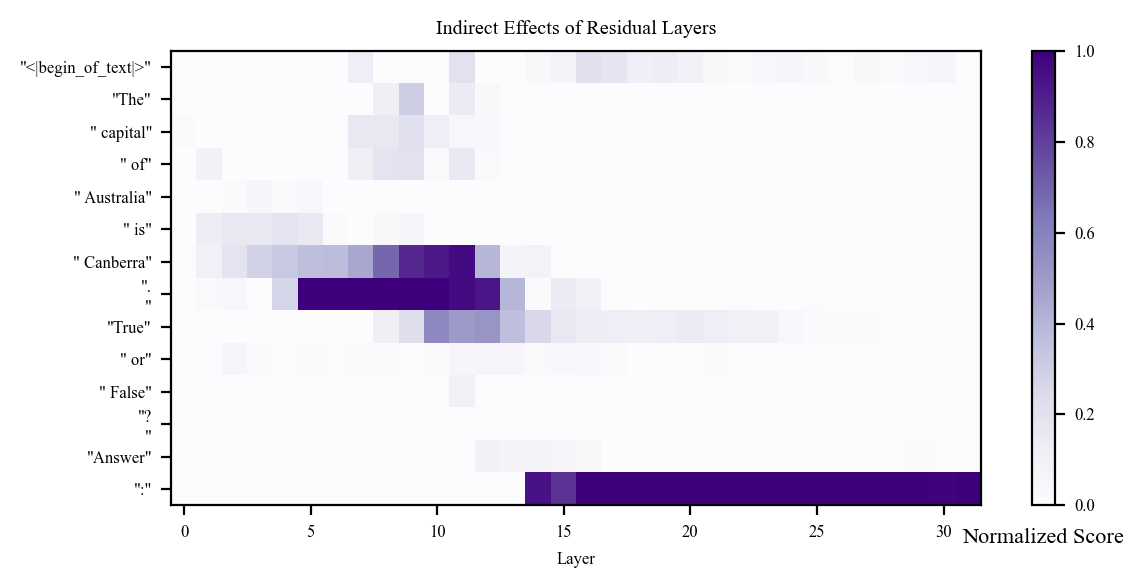

Data shape: (14, 32)
Number of tokens: 14


In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D array: layers as rows, tokens as columns, then transpose
scores = np.array(torch.tensor(patched_activations)).T  # Transpose so tokens are rows, layers are columns
print(f"Scores shape after transpose: {scores.shape}")

# Decode tokens to actual text
corrupt_tokens = [model.tokenizer.decode([token_id]) for token_id in enc_rhet[prefix_len:]]
clean_tokens = [model.tokenizer.decode([token_id]) for token_id in enc_clean]

# Create token labels
tokens = []
for idx, (corrupt_tok, clean_tok) in enumerate(zip(corrupt_tokens, clean_tokens)):
    tokens.append(f'"{clean_tok}"')

# We will truncate to the 0 to 1 range to prioritize positive values
# but this is the full actual range.
print(f"Data range: min={scores.min():.4f}, max={scores.max():.4f}")

plt.rcdefaults()
with plt.rc_context(
    rc={
        "font.family": "Times New Roman",
        "font.size": 6,
    }
):
    # Set figure size
    fig, ax = plt.subplots(
        figsize=(
            6,
            len(tokens) * 0.08 + 1.8
        ),
        dpi=200
    )
    
    # Scale range
    scale_kwargs = {
        "vmin": 0,
        "vmax": 1
    }

    heatmap = ax.pcolor(
        scores,
        cmap="Purples",
        **scale_kwargs,
    )

    ax.invert_yaxis()
    
    # Y-axis: token labels (rows)
    ax.set_yticks([0.5 + i for i in range(scores.shape[0])])  # Number of tokens
    ax.set_yticklabels(tokens)
    
    # X-axis: layer labels (columns)
    num_layers = scores.shape[1]
    tick_indices = np.arange(0, num_layers, 5)
    ax.set_xticks(tick_indices + 0.5)  # Number of layers
    ax.set_xticklabels(tick_indices)

    title = f"Indirect Effects of Residual Layers"
    ax.set_title(title)

    ax.set_xlabel("Layer")
    #ax.set_ylabel("Tokens")

    color_scale = plt.colorbar(heatmap)
    color_scale.ax.set_title(
        f"Normalized Score",
        y=-0.12,
        fontsize=8
    )

    plt.tight_layout()
    plt.show()

print(f"Data shape: {scores.shape}")
print(f"Number of tokens: {len(tokens)}")

